In [12]:
!pip install konlpy
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54388 sha256=07d88086d123f76c67afa952cdf626bac3536567cc1bc4994eea0f605ffff704
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [13]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from summa import keywords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional, Dropout, GRU

In [14]:
tokenizer = Tokenizer()

In [15]:
data = pd.read_csv('file (3).csv', encoding='utf-8')

In [16]:
text = data['cleaned_info'].apply(lambda a : re.findall('[가-힣a-z]+', a))

In [ ]:
text.apply(lambda a : a.append('<eos>'))

In [18]:
tokenizer.fit_on_texts(text)

In [19]:
vocab_n = len(tokenizer.word_index) + 1
vocab_n

13657

In [20]:
embeded = tokenizer.texts_to_sequences(text)

In [21]:
pad_len = 10
def Padding (text) :
    lists = []
    for ind in range(1, len(text)) :
        if ind < pad_len + 1 :
            words = text[:ind + 1]
        else :
            words = text[ind - pad_len : ind + 1]
        lists.append(words)
    return pad_sequences(lists, pad_len + 1, padding = 'pre')

In [22]:
t_data = list(map(Padding, embeded))

In [23]:
data = []
for i in t_data :
    for j in i :
        data.append(j)

In [24]:
X = []
y = []
for i in data :
    y.append(np.array(list(i).pop(-1)))
    X.append(i[:-1])

In [25]:
X = np.array(X)
y = np.array(y)

In [ ]:
input = tf.keras.Input(shape=(pad_len, ))
x = tf.keras.layers.Embedding(vocab_n, 256)(input)
x = tf.keras.layers.LSTM(512, return_sequences = False)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
output = tf.keras.layers.Dense(vocab_n, activation = 'softmax')(x)

model = tf.keras.Model(inputs = input, outputs = output)

In [359]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 10)]              0         
                                                                 
 embedding_16 (Embedding)    (None, 10, 256)           3496192   
                                                                 
 lstm_16 (LSTM)              (None, 512)               1574912   
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dense_33 (Dense)            (None, 13657)             7006041   
                                                                 
Total params: 12339801 (47.07 MB)
Trainable params: 12339801 (47.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


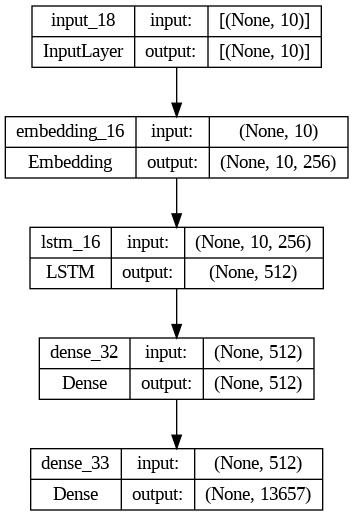

In [360]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.05),
              metrics = ['acc'])

In [ ]:
model.fit(X, y, epochs = 50, batch_size = 4096)

In [363]:
def sentence_generation(model, tokenizer, current_word): # 모델, 토크나이저, 키워드(단어 여러개 가능)
    current_word = current_word.split(' ')

    # n번 반복
    for _ in range(30):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])
        encoded = pad_sequences(encoded, maxlen=pad_len, padding='pre')

        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        pred = model.predict(encoded, verbose = 0)

        top_k = np.argsort(pred[0])[:-4:-1]
        ind = np.random.choice([0,0,0,0,1,1,2]) # random으로 상위 0~2위의 단어를 result로 할당한다
        result = tokenizer.index_word.get(top_k[ind])

        if result == 'eos' :
            break
        words = result.split(' ')

        if len(words) != 1 and result == words[-1] :
            continue
        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word.append(result)

    return current_word

In [ ]:
print(tokenizer.word_index)

{'하다': 1, '서비스': 2, '하고': 3, '플랫폼': 4, '되다': 5, '제공': 6, '<eos>': 7, '개발': 8, '기술': 9, '기반': 10, '통해': 11, '기업': 12, 'ai': 13, '관리': 14, '솔루션': 15, '데이터': 16, '년': 17, '만들다': 18, '테크': 19, '정보': 20, '제품': 21, '시스템': 22, '가능하다': 23, '다양하다': 24, '콘텐츠': 25, '운영': 26, '기능': 27, '시장': 28, '활용': 29, '사용': 30, '보다': 31, 'saas': 32, '분석': 33, '고객': 34, '국내': 35, '사업': 36, '받다': 37, '되어다': 38, '판매': 39, '제작': 40, '쉬다': 41, '공유': 42, '않다': 43, '없다': 44, '모든': 45, '브랜드': 46, '위해': 47, '이용': 48, '현재': 49, '사람': 50, '경험': 51, '스마트': 52, '대한': 53, '디지털': 54, '확인': 55, '전문': 56, '새롭다': 57, '추천': 58, '여행': 59, '지능': 60, '해결': 61, '온라인': 62, '영상': 63, '투자': 64, '생산': 65, '공간': 66, '월': 67, '거래': 68, '교육': 69, '사용자': 70, '지원': 71, '목표': 72, '건강': 73, '인공': 74, '글로벌': 75, '필요하다': 76, '자동': 77, '기록': 78, '맞춤': 79, '상품': 80, '문제': 81, '진행': 82, '기존': 83, '버스': 84, '개인': 85, '빠르다': 86, '늘다': 87, '산업': 88, '회사': 89, '가다': 90, '환경': 91, '크다': 92, '게임': 93, '제조': 94, '분야': 95, '구축': 96, '시작': 97, '식품': 98, '스타

In [364]:
generate = sentence_generation(model, tokenizer, '특수') # 사용 예시
print(generate)

['특수', '진행', '지능', '지능', '지능', '지능', '진행', '지능', '지능', '지능', '지능', '지능', '진행', '지능', '지능', '하다', '진행', '진행', '지능', '되어다', '진행', '지능', '지능', '하다', '지능', '진행', '되어다', '제공', '지능', '진행', '진행']


In [26]:
from summa import keywords
import gensim
from konlpy.tag import Hannanum, Okt, Kkma
from gensim.models import Word2Vec
from gensim.models import FastText as FT
from gensim.models.keyedvectors import KeyedVectors
okt = Okt()

In [97]:
def Extractor(list) : # keyword는 ['단어', '단어', ...] 형식으로 받는다
    words_n = 3 # 뽑을 키워드 갯수
    keyword = []

    string = okt.nouns(' '.join(list)) # 명사만 찾는다
    string = ' '.join(string) # findall을 하기위해 묶는다
    keyword = ' '.join(re.findall('\w{2,}', string.lower())) # 1글자인 단어들 삭제

    if len(set(keyword)) < words_n :
        words_n = len(set(keyword)) # 단어 갯수가 적을 경우 뽑을 키워드 갯수를 낮춘다
    try :
        keyword = keywords.keywords(keyword, words = words_n) # 키워드 뽑기
    except :
        words_n -= 1
        keyword = keywords.keywords(keyword, words = words_n)
    keyword = keyword.replace('\n', ' ')
    return keyword.split(' ')

In [ ]:
test = text[0]
test

In [72]:
a = Extractor(test)

In [73]:
a

['일기', '기록', '내용']

In [ ]:
train_data = data['cleaned_info'].apply(lambda a : re.findall('[가-힣a-z]+', a)).to_list()

In [ ]:
w2v_model = Word2Vec(sentences = train_data, vector_size = 50, window = 5, min_count = 0, workers = 4, sg = 0) # 가진 데이터로 학습

In [ ]:
pre_model = KeyedVectors.load_word2vec_format('cc.ko.300.vec') # 학습된 모델

In [358]:
def Simmilarity(keyword1, keyword2) : # 문장1의 키워드, 문장2의 키워드를 받는다. keyword2에 사용자 키워드를 가져와야 한다
    vector_dic = {}
    score = 0

    for i in [keyword1, keyword2] :
        for ind, keyword in enumerate(i) :
            i[ind] = np.round(pre_model.wv[keyword], decimals=3) # 벡터값을 vector_dic에 저장

    for i in keyword1 :
        for j in keyword2 :
            score += i.dot(j.T) # scaled dot
    return score/len(keyword1) # attention score를 다 더하고 query 갯수만큼 나누었다. float 형태로 나온다

In [48]:
def To_dic(keyword) :

    dic = {}
    for ind, i in enumerate(keyword) :
        dic[i] = keyword[ind][1]

    return dic

In [ ]:
Simmilarity([['일기', 0.41], ['기록', 0.41], ['내용', 0.31]], [['롤플레잉', 0.4], ['캐릭터', 0.4], ['채팅', 0.23]]) # 사용 예시

27.06449285507202

In [9]:
a = [['일기', 0.41], ['기록', 0.41], ['내용', 0.31]]
b = [['롤플레잉', 0.4], ['캐릭터', 0.4], ['내용', 0.31]]
# for keyword in a :
#     if keyword not in b :
#         b.append(keyword)
a+b

[['일기', 0.41],
 ['기록', 0.41],
 ['내용', 0.31],
 ['롤플레잉', 0.4],
 ['캐릭터', 0.4],
 ['내용', 0.31]]

In [ ]:
# 아이디어 만든게 n 개라고 가정하자.

In [49]:
dic = To_dic([['일기', 0.41], ['기록', 0.41], ['내용', 0.31]])

In [50]:
dic[0]

{'일기': 0.41, '기록': 0.41, '내용': 0.31}

In [ ]:
dic = pd.read_csv('generated_sentences.txt')

In [59]:
dic.columns = ['sentence']

In [60]:
sent = dic['sentence']

In [92]:
key_dic[0] = Extractor(sent[0].split())

In [93]:
key_dic

{'ind': ['세상', '제작', '랭킹'], 1: ['개인', '기반', '중개'], 0: ['개인', '기반', '중개']}

In [98]:
key_dic = {}
for ind, i in enumerate(sent) :
    i = i.split()
    key_dic[ind] = Extractor(i) # 아이디어 데이터의 index 와 키워드를 딕셔너리로 묶는다.


In [102]:
for i in key_dic.keys() :
    key_dic[i] = Simmilarity(key_dic[i], ideal_vec)

NameError: name 'Simmilarity' is not defined